# Drell Yan rejection ( based on CMS Higg &rarr; WW method)

Oct. 21

In [1]:
run old_prep_ana.py

loading data frame named df.
finished loading data frame
unc_mc_process and scales are dictionaries
scale_data = (5.27/19.7)


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

In [31]:
def pre_cuts( df ):
    dif_lep = df.lep_Type > 0
    sam_lep = df.lep_Type < 0
    z_mass = (df.mll < 76) | (df.mll > 106 )
    qt_s = (df.qT > 45)
    qt_d = (df.qT > 30)
    met_prj = df.METProj_sin > 20
    nbjet = df.nBJet == 0
    
    s_df = df[ sam_lep & met_prj & qt_s & z_mass & nbjet]
    d_df = df[ dif_lep & met_prj & qt_d & nbjet]
    
    return pd.concat([ s_df, d_df])
    

In [4]:
#load root files
df_WW = rp.read_root("data/WW_tot_complete.root", "trees_vec")
df_DY = rp.read_root("data/DY_ll_complete.root", "trees_vec")
df_TT = rp.read_root("data/TT_ll_complete.root", "trees_vec")

In [32]:
df = pd.concat( [df_WW, df_TT, df_DY] )
df = pre_cuts(df)
df = df.reset_index()

In [33]:
for process in df.process.unique():
    print process, df[(df.process==process) ].shape[0] * scales[process]
print df_TT.shape, df_TT[(df_TT.nBJet==0) ].shape

WW 6043.0695377
TT 15833.3989022
DY 13205.4992311
(1631022, 58) (627533, 58)


In [7]:
train_DY = df[df.process=="DY"].sample( frac= 0.45 )
train_WW = df[df.process=="WW"].sample( n=train_DY.shape[0]*2 )
train_TT = df[df.process=="TT"].sample( n=train_WW.shape[0]*2 )
train = pd.concat( [train_WW, train_DY, ] )

print train_DY.shape
print train_WW.shape
print train_TT.shape

test = df.drop( train.index )
print train.shape, test.shape

(2680, 59)
(5360, 59)
(10720, 59)
(8040, 59) (1017271, 59)


In [8]:
print test[test.process == "WW"].shape
print test[test.process == "DY"].shape
print test[test.process == "TT"].shape

(46269, 59)
(3275, 59)
(967727, 59)


In [9]:
features = [  'METProj_sin', 'met_over_sET','METProj_trk_sin', 'qT', 'mllMET', 'recoil', 'jetPt1', 'dPhiLLJet', 'dPhiLLMET', 'dPhiMETJet', 'lep_Type' ]

In [10]:
#labels
labels = np.empty( train.shape[0] )
weights = np.empty( train.shape[0])

labels[(train.process == "WW").as_matrix()] = 1
labels[(train.process == "DY").as_matrix()] = 2

weights[(train.process == "WW").as_matrix()] = 1
weights[(train.process == "DY").as_matrix()] = 1

In [11]:
#labels
train_0 = train[train.numb_jets==0]

labels_0 = np.empty( train_0.shape[0] )
weights_0 = np.empty( train_0.shape[0])

labels_0[(train_0.process == "WW").as_matrix()] = 1
labels_0[(train_0.process == "DY").as_matrix()] = 2

weights_0[(train_0.process == "WW").as_matrix()] = 1
weights_0[(train_0.process == "DY").as_matrix()] = 1

In [12]:
#labels
train_1 = train[train.numb_jets==1]
labels_1 = np.empty( train_1.shape[0] )
weights_1 = np.empty( train_1.shape[0])

labels_1[(train_1.process == "WW").as_matrix()] = 1
labels_1[(train_1.process == "DY").as_matrix()] = 2

weights_1[(train_1.process == "WW").as_matrix()] = 1
weights_1[(train_1.process == "DY").as_matrix()] = 1

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf = clf.fit( np.float32(train[features].values) , np.float32(labels), sample_weight=weights)

clf_0 = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf_0 = clf_0.fit( np.float32(train_0[features].values) , np.float32(labels_0), sample_weight=weights_0)

clf_1 = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf_1 = clf_1.fit( np.float32(train_1[features].values) , np.float32(labels_1), sample_weight=weights_1)

In [14]:
print clf.score(np.float32(train[features].values), np.float32(labels), weights)

0.974004975124


In [57]:
#labels and weights
df_labels = np.empty( df.shape[0] )
df_weights = np.empty( df.shape[0])

df_labels[(df.process == "WW").as_matrix()] = 1
df_labels[(df.process == "DY").as_matrix()] = 2
df_labels[(df.process == "TT").as_matrix()] = 3

df_weights[(df.process == "WW").as_matrix()] = 1.
df_weights[(df.process == "DY").as_matrix()] = 1
df_weights[(df.process == "TT").as_matrix()] = 1

print clf.score(np.float32(df[features].values), np.float32(df_labels), df_weights)

0.0450790052969


In [15]:
pred = clf.predict_proba(np.float32(test[features].values))
pred_0 = clf_0.predict_proba(np.float32(test[features].values))
pred_1 = clf_1.predict_proba(np.float32(test[features].values))

test["pred_WW_0"] = pred_0[:,0]
test["pred_WW_1"] = pred_1[:,0]
test["pred_WW"] = pred[:,0]
#test["pred_TT"] = pred[:,1]

In [29]:
labels_0

array([  1.00000000e+000,   1.00000000e+000,   1.00000000e+000, ...,
         3.43217523e-319,   3.43301514e-319,   3.43770876e-319])

# Results

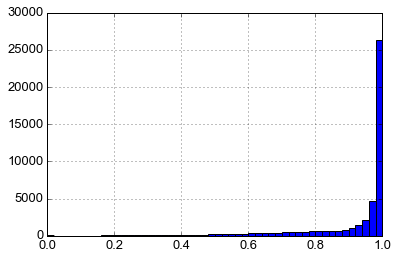

In [16]:
test[ (test.process == "WW") ].pred_WW_0.hist( bins= 50)

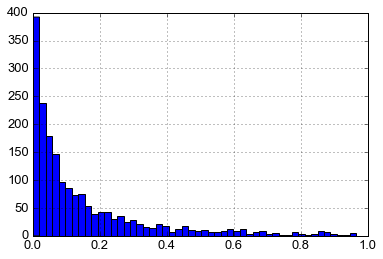

In [28]:
test[ (test.process == "DY")&(test.numb_jets==1) ].pred_WW_1.hist( bins= 50)

In [43]:
cut = 0.4
jets_cuts_0 = (test.pred_WW_0 > .9) & (test.numb_jets==0)
jets_cuts_1 = (test.pred_WW_1 > .8) & (test.numb_jets==1)
feature_cuts = (test.numbExtraLep == 0) & jets_cuts_0 & (test.nBJet ==0)
feature_cuts_diff =( test.lep_Type > 0 ) & feature_cuts
feature_cuts_same = (test.lep_Type < 0) & feature_cuts #& (test.METProj_trk_sin > 30)
print "\tdiff", "\tsame"
for process in scales.keys():
    if process in test.process.unique():
        print process, test[ (test.process == process) & feature_cuts_diff].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0]),\
    test[ (test.process == process) & feature_cuts_same].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0])

	diff 	same
WW 2794.21274913 941.417476664
DY 60.4832025852 68.5476295966
TT 178.33960201 68.7998189404


In [ ]:
WW vs DY 

~.9
diff 	same
WW 3855.29613889 1342.28560569
DY 261.675381398 211.832451608
TT 5308.53201509 1709.83792635

0.001
	diff 	same
WW 3942.68285137 1664.63119953
DY 677.033129648 8290.54065507
TT 5727.48294491 2725.99606217

In [62]:
process = "TT"
test[ (test.process == process) ].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0]),\

(40964.95164763091,)

In [63]:
print df[df.process == "WW"].shape[0] * scales["WW"]
print df[df.process == "DY"].shape[0] * scales["DY"]
print df[df.process == "TT"].shape[0] * scales["TT"]

6081.94384222
13602.9662552
40964.9516476


	diff 	same
WW 2204.78826763 1369.25184188
DY 16.6144293589 319.82776516
TT 16570.9933715 9587.59438988


In [97]:
s_ww = float(df[df.process == "WW"].shape[0])/float(test[test.process == "WW"].shape[0])
s_dy = float(df[df.process == "DY"].shape[0])/float(test[test.process == "DY"].shape[0])
s_tt = float(df[df.process == "TT"].shape[0])/float(test[test.process == "TT"].shape[0])

(<matplotlib.axes._subplots.AxesSubplot at 0x117bbea90>,
 [<Container object of 50 artists>,
  <Container object of 50 artists>,
  <Container object of 50 artists>,
  <Container object of 50 artists>,
  <Container object of 50 artists>,
  <Container object of 50 artists>,
  <Container object of 50 artists>],
 ['WW', 'TT', 'WZ', 'ZZ', 'DY'])

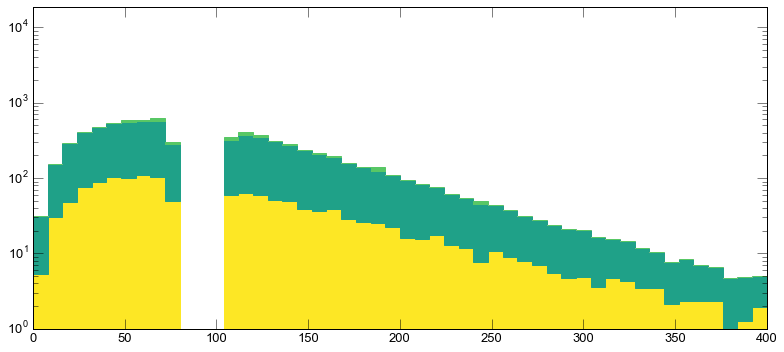

In [99]:
feature = 'mll'
range= (0,400)#(-.5,9.5)
cut = 0.905#.954
bins=50
#test.METProj_trk_sin

cuts = (test.pred_WW > cut) & (test.lep_Type < 0)

bin_mc = bin_df( test[cuts], feature, range=range, scales={"WW":scales["WW"] * s_ww, "DY":scales["DY"] * s_dy, "TT":scales["TT"] * s_tt ,\
                                                          'WZ_2l2q': 1, 'WZ_3ln': 1, 'ZZ':1, "WZ":1}, bins=bins)
plot_hist(bin_mc, )#processes=["DY","TT","WW"])#y_range=True, logy=False)

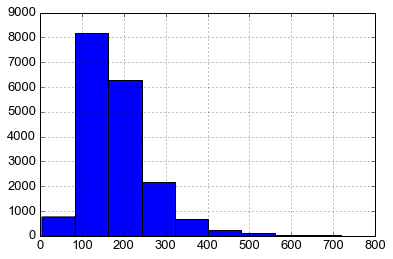

In [85]:
train[train.mllMET < 800].mllMET.hist()

In [18]:
scales

{'DY': 2.2842932418457296,
 'Da': 1,
 'TT': 0.04233110334591358,
 'WJ': 1,
 'WW': 0.11780092278022818,
 'WZ': 0.010445599285225466,
 'WZ_2l2q': 0.013721435700981659,
 'WZ_3ln': 0.010445599285225466,
 'ZZ': 0.018152313266614338}

# END


In [22]:
3516 + 1390 + 1113 + 386

6405

In [37]:
for e, f in enumerate( features ):
    print f, clf.feature_importances_[e]

numb_jets 0.124136276537
METProj_sin 0.108295603378
met_over_sET 0.0643512460966
METProj_trk_sin 0.0880652792855
qT 0.0486501765046
mllMET 0.0502196537317
recoil 0.0729385073004
jetPt1 0.151214760348
dPhiLLJet 0.142864325925
dPhiLLMET 0.0448394408675
dPhiMETJet 0.104424730025


In [41]:
print df_TT.shape
print df_TT[df_TT.HT < 70].shape
print "org is ", float(df_TT.shape[0]) / float(df_TT[df_TT.HT < 70].shape[0]), "x larger"

(1631022, 58)
(203697, 58)
org is  8.00709877907 x larger


In [42]:
print df_WW.shape
print df_WW[df_WW.HT < 70].shape
print "org is ", float(df_WW.shape[0]) / float(df_WW[df_WW.HT < 70].shape[0]), "x larger"

(113599, 58)
(99701, 58)
org is  1.13939679642 x larger
